In [3]:
import numpy as np
# uncomment and run the line below to install pyqsp
# %pip install pyqsp
from pyqsp import phases, response 
import matplotlib.pyplot as plt

[pyqsp.fixed_point_search] generating length 20 sequence in the Wx convention
[phi_fp]: gamma=0.9980368020961987


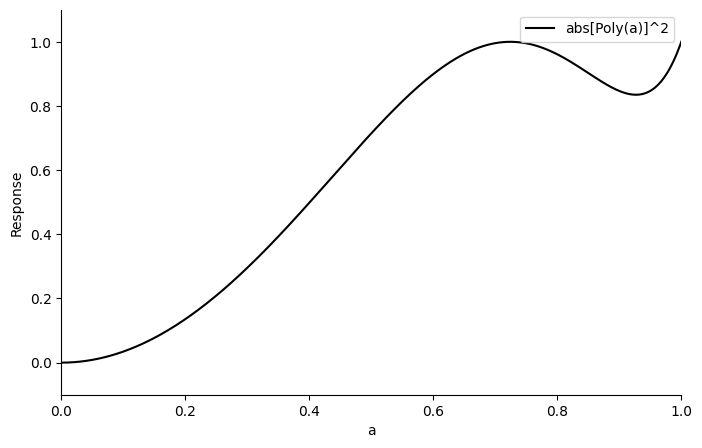

In [4]:
phis = phases.FPSearch().generate(10, 0.5)
response.PlotQSPResponse(phis, plot_positive_only=True, plot_probability = True, plot_tight_y=True, npts = 400, measurement='z')

[pyqsp.fixed_point_search] generating length 200 sequence in the Wx convention
[phi_fp]: gamma=0.9999997504010151


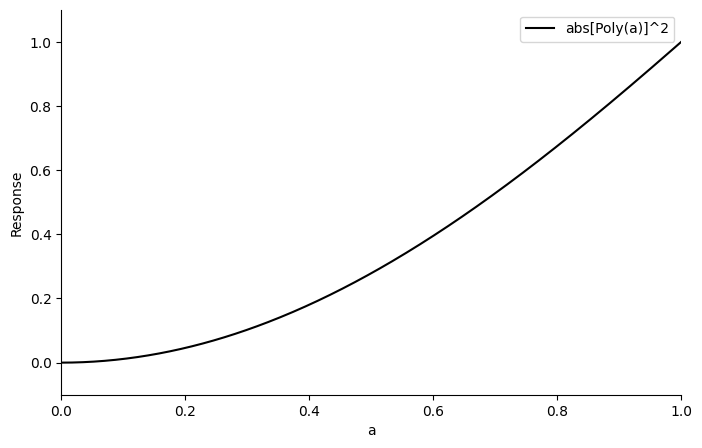

In [5]:
phis = phases.FPSearch().generate(100, 0.99)
response.PlotQSPResponse(phis, plot_positive_only=True, plot_probability = True, plot_tight_y=True, npts = 400, signal_operator='Wx', measurement='z')

In [65]:
def Rx_response(a, phases):
    UPhi = np.array([[1, 0], [0, 1]])
    U = np.array([[a, np.sqrt(1-a**2)],
                [np.sqrt(1 - a**2), -a]])
    for p in phases:
        Pi = np.array([[np.exp(1j * p/2), 0], [0, np.exp(-1j*p/2)]])
        UPhi = UPhi @ U @ Pi
    UPhi = UPhi @ U
    v = np.array([
        [1],
        [0]
    ])
    t = np.array([
        [1],
        [0]
    ])
    return t.T @ UPhi @ v

In [66]:
def amplify_phases(d, delta):
    L = 2 * d + 1
    kvec = np.arange(1, d + 1)
    gamma = 1 / np.cosh((1 / L) * np.arccosh(1 / delta))
    sg = np.sqrt(1 - gamma**2)
    avec = -2 * np.arctan2(1, (np.tan(2 * np.pi * kvec / L) * sg))

    bvec = avec[::-1]
    phivec = np.zeros(2 * d)
    for k in range(d):
        phivec[2 * k] = avec[d - k - 1]
        phivec[2 * k + 1] = bvec[d - k - 1]
    return phivec


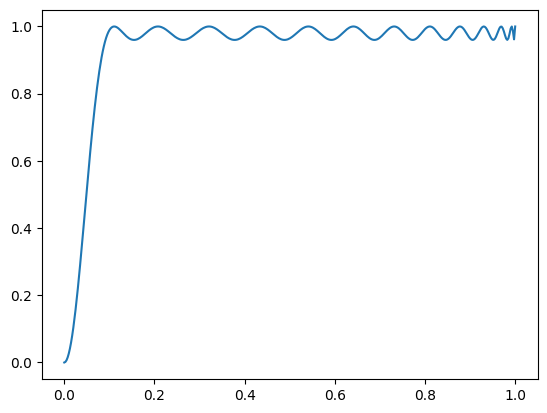

In [67]:
xs = np.linspace(0,1, 400)
phi = amplify_phases(12, 0.2)
responses = []
for x in xs:
    responses.append(np.absolute(Rx_response(x, phi)[0,0])**2)
plt.plot(xs, responses)

In [79]:
def suppress_phases(d, delta):
    d = int(d)
    L = 2*d + 1
    phivec = []
    gamma = 1 / np.cosh((1 / L) * np.arccosh(1 / delta))
    sg = np.sqrt(1 - gamma**2)
    for k in range(1, d+1):
        phivec.append(-2*np.arctan2(1, sg * np.tan((2*k-1)*np.pi/L) ))
        phivec.append(-2*np.arctan2(1, sg * np.tan((2*k)*np.pi/L) ))
    return np.array(phivec)

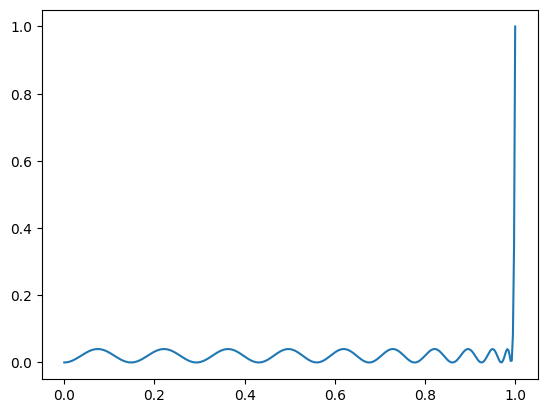

In [82]:
xs = np.linspace(0,1, 400)
phi = suppress_phases(10, 0.2)
responses = []
for x in xs:
    responses.append(np.absolute(Rx_response(x, phi)[0,0])**2)
plt.plot(xs, responses)